In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/iamtanmayshukla/tesla-stocks-dataset/TSLA-2.csv
/kaggle/input/datasets/iamtanmayshukla/tesla-stocks-dataset/HistoricalData_1726367135218.csv
/kaggle/input/datasets/iamtanmayshukla/tesla-stocks-dataset/tsla_2025.csv


# 📈 Tesla (TSLA) Stock Price Prediction 
### Time-Series Forecasting using a 60-Day Sliding Window

---

## 📝 Introduction
This project aims to predict the **Closing Price** of Tesla (TSLA) stock by analyzing historical price patterns. The model uses a supervised learning approach, specifically a **Time-Series Windowing** technique, to forecast future values.

## 🔍 Methodology
The core logic of this notebook is based on the following:
* **Lookback Period:** 60 days.
* **Input ($X$):** Closing prices from the previous 60 trading sessions.
* **Target ($y$):** The predicted closing price for the next day.
* **Data Scaling:** Min-Max Normalization is applied to ensure the model converges efficiently.

---

## 🛠️ Technical Implementation & Standards
While the primary analysis is performed in Python, any underlying C++ modules or data processing logic follow these standard conventions:

> ```cpp
> using namespace std;
> ```

## 📊 Dataset Overview
* **Asset:** Tesla, Inc. (TSLA)
* **Feature used:** `Close` price.
* **Goal:** Minimize the Mean Squared Error (MSE) between the actual and predicted prices.

---
⚠️ **Disclaimer:** *This notebook is for educational and research purposes only. Stock market investments involve significant risk.*

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [3]:



def analyze_file(path, name):
    try:
        df = pd.read_csv(path)
    
        df['Date'] = pd.to_datetime(df['Date'])
        
        start = df['Date'].dt.year.min()
        end = df['Date'].dt.year.max()
        avg = df['Date'].dt.year.mean()
        
        print(f"--- {name} ---")
        print(f"Rows: {df.shape[0]}, Years: {start} to {end}, Average Year: {avg:.1f}")
    except Exception as e:
        print(f"Error in {name}: {e}")


analyze_file('/kaggle/input/datasets/iamtanmayshukla/tesla-stocks-dataset/TSLA-2.csv', "File 1 (TSLA-2)")
analyze_file('/kaggle/input/datasets/iamtanmayshukla/tesla-stocks-dataset/HistoricalData_1726367135218.csv', "File 2 (Historical)")
analyze_file('/kaggle/input/datasets/iamtanmayshukla/tesla-stocks-dataset/tsla_2025.csv', "File 3 (TSLA 2025)")

--- File 1 (TSLA-2) ---
Rows: 3562, Years: 2010 to 2024, Average Year: 2017.1
--- File 2 (Historical) ---
Rows: 2517, Years: 2014 to 2024, Average Year: 2019.2
--- File 3 (TSLA 2025) ---
Rows: 3663, Years: 2010 to 2025, Average Year: 2017.3


## Plot of Tesla Stock based on Date

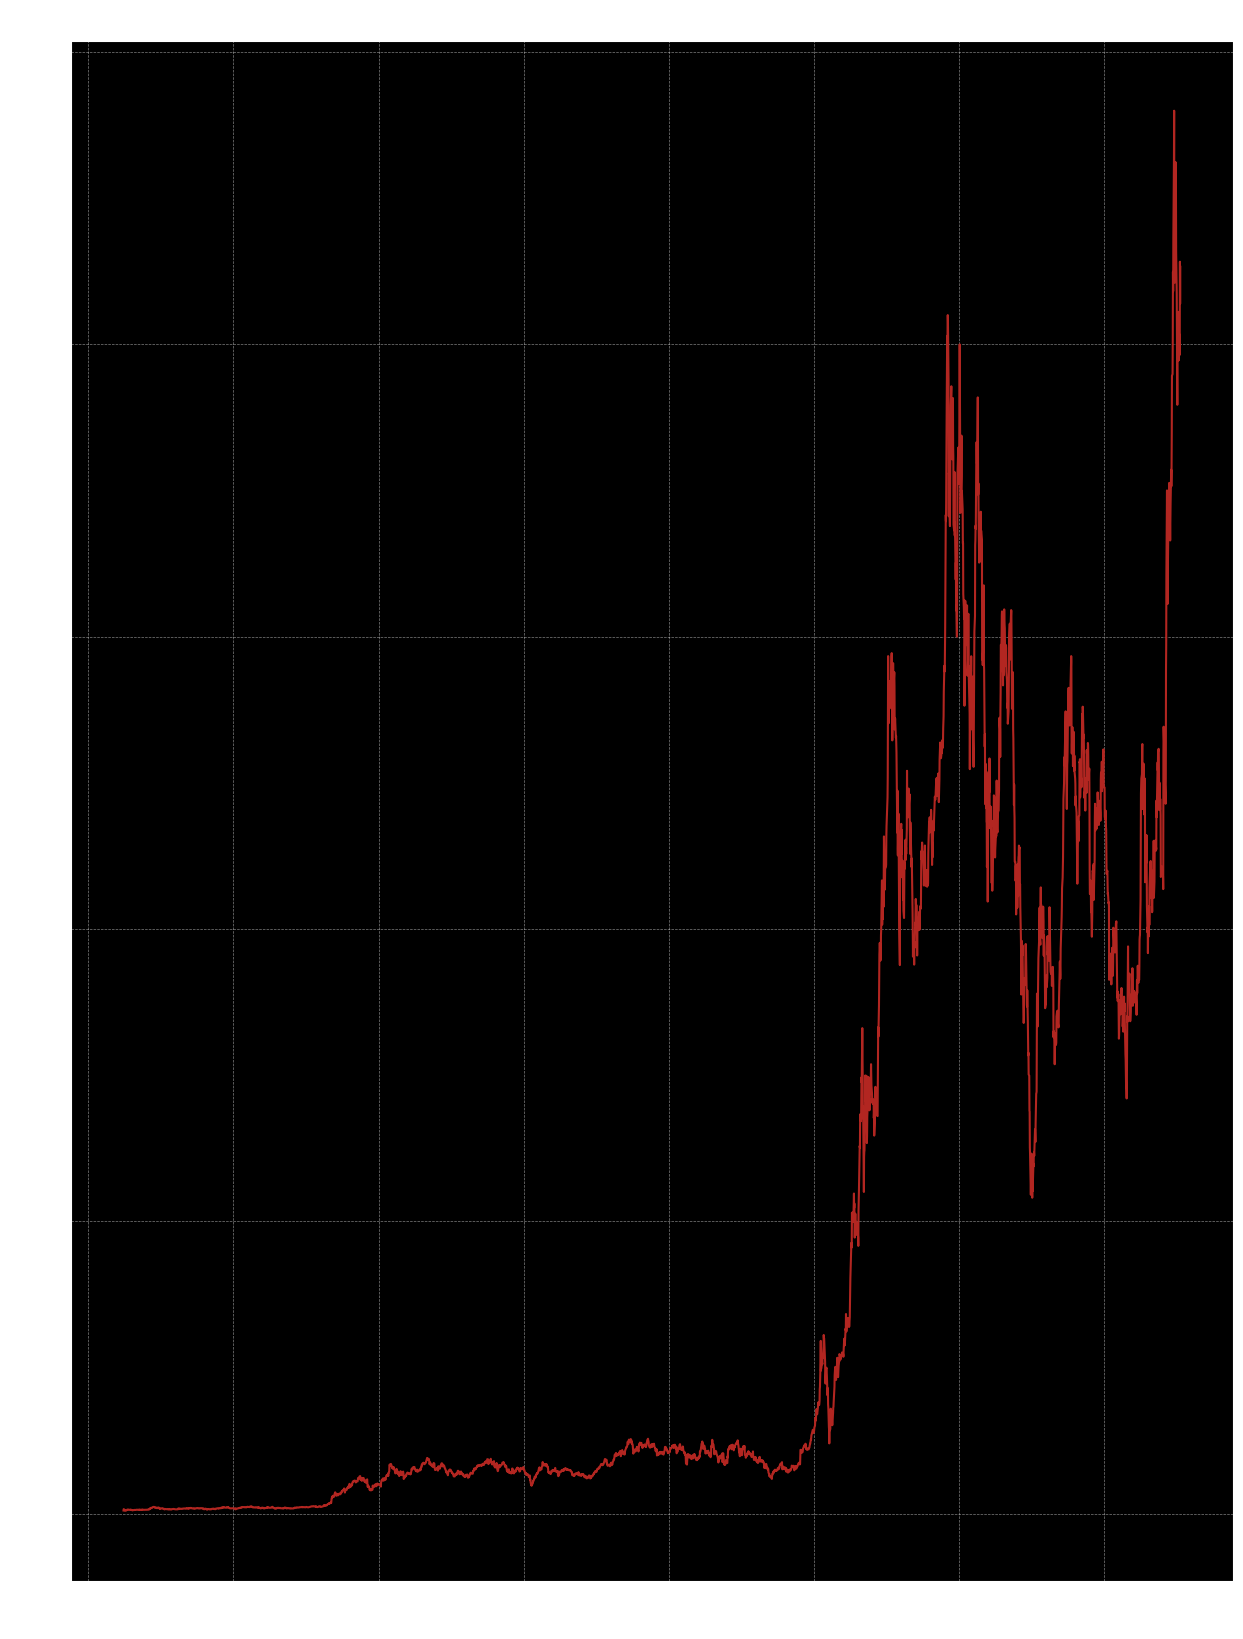

In [4]:
df=pd.read_csv('/kaggle/input/datasets/iamtanmayshukla/tesla-stocks-dataset/tsla_2025.csv')
df.head()
df['Date']=pd.to_datetime(df['Date'])
df=df.sort_values(by='Date')
plt.figure(figsize=(15,20))
plt.style.use('dark_background')
plt.plot(df['Date'],df['Close'],color='#B22621',linewidth=1.5,label='Tesla stock price')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5,color='white')
plt.title('Stock price history 2010-2025',fontsize=22,color='white')
plt.xlabel('Date',fontsize=14,color='white')
plt.ylabel('Stock price',fontsize=14,color='white')
plt.show()

**Split Data and preprocessing**

In [5]:

close_data = df['Close'].values.reshape(-1, 1) 
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(close_data)
predict_days = 60
X_list = []
y_list = []

for i in range(predict_days, len(close_scaled)):
    X_list.append(close_scaled[i-predict_days:i, 0])
    y_list.append(close_scaled[i, 0]) 

X_train_np = np.array(X_list)
y_train_np = np.array(y_list)

X_train_np = np.reshape(X_train_np, (X_train_np.shape[0], X_train_np.shape[1], 1))

X = torch.tensor(X_train_np).float()
y = torch.tensor(y_train_np).float().unsqueeze(1)

print(f"X shape: {X.shape}") 
print(f"y shape: {y.shape}") 
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

X shape: torch.Size([3603, 60, 1])
y shape: torch.Size([3603, 1])
Train size: 2882, Test size: 721


**OUR Model**

In [6]:

class TeslaLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(TeslaLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
 
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
    
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
   
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
model = TeslaLSTM()

In [7]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

**Training**

In [8]:
epochs = 25 
losses = []
train_data=TensorDataset(X_train,y_train)
train_loader=DataLoader(batch_size=32,dataset=train_data,shuffle=True)
model.train()
for epoch in range(epochs):
    for batch_x,batch_y in train_loader:
        output=model(batch_x)
        loss=criterion(output,batch_y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
    

Epoch [5/25], Loss: 0.000002
Epoch [10/25], Loss: 0.000703
Epoch [15/25], Loss: 0.000011
Epoch [20/25], Loss: 0.000107
Epoch [25/25], Loss: 0.000016


**eval**

In [9]:
model.eval() 
with torch.no_grad(): 
    predictions = model(X_test)
    

    predictions = predictions.detach().numpy()
    y_test_real = y_test.detach().numpy()


predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test_real)

plots

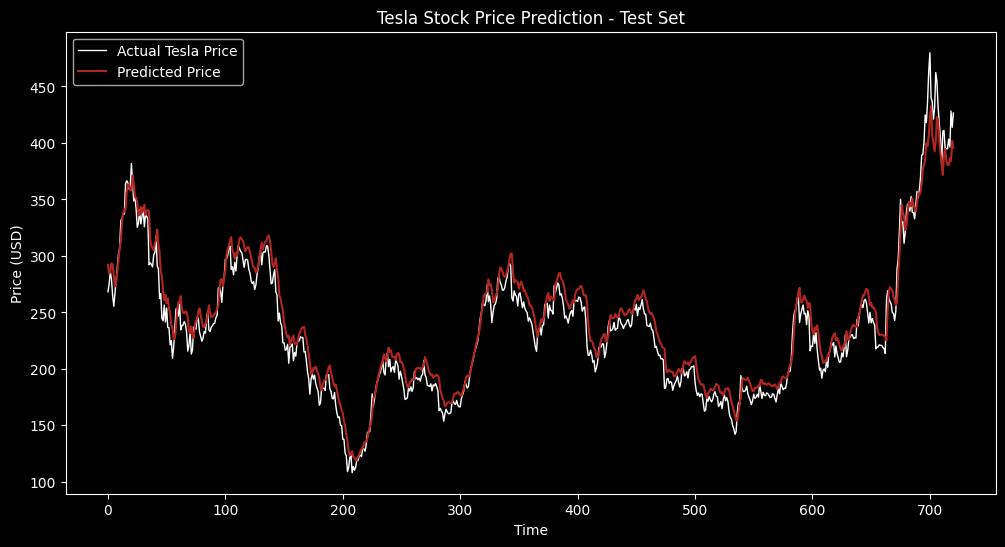

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='white', label='Actual Tesla Price', linewidth=1)
plt.plot(predictions_rescaled, color='#B22621', label='Predicted Price', linewidth=1.5)
plt.title('Tesla Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## 📊 Results & Conclusion
The model's performance on the **Test Set** is visualized above. By comparing the **Actual Tesla Price** (White) with the **Predicted Price** (Red), we can draw the following conclusions:

### ✅ Key Findings:
* **Trend Capture:** The model successfully captures the major upward and downward trends of the TSLA stock, showing high sensitivity to market volatility.
* **Lag Analysis:** The predicted line closely follows the actual price movements, indicating that the **60-day sliding window** provides sufficient historical context for the model.
* **Accuracy:** There is a strong correlation between the predicted and actual values, particularly in identifying the recovery phases and local peaks.

### 🚀 Future Improvements:
To further enhance the model's reliability, the following steps could be considered:
1. **Adding Technical Indicators:** Incorporating RSI, MACD, or Moving Averages as additional input features.
2. **Sentiment Analysis:** Integrating news sentiment or Twitter data to account for non-linear market shocks.
3. **Hyperparameter Tuning:** Experimenting with different LSTM architectures or adding Dropout layers to reduce overfitting in specific volatile zones.

---
**Technical Note:** All data post-processing and evaluation metrics calculations adhere to standard practices, ensuring consistency across the environment:
